## Training

In [1]:
import json
import random
from collections import defaultdict, Counter
from tqdm import tqdm
import math

# -------------------
# Load train/val/test
# -------------------
with open("train-data.json") as f:
    train_data = json.load(f)
with open("val-data.json") as f:
    val_data = json.load(f)
with open("test-data.json") as f:
    test_data = json.load(f)

# Convert from [{word:tag}, ...] to list of (word, tag)
def convert_back(data):
    return [[(list(d.keys())[0].lower(), list(d.values())[0]) for d in sent] for sent in data]

train_data = convert_back(train_data)
val_data   = convert_back(val_data)
test_data  = convert_back(test_data)

# -------------------
# HMM Training (MLE)
# -------------------
class HMMTagger:
    def __init__(self):
        self.tags = set()
        self.words = set()
        self.init_probs = defaultdict(float)
        self.trans_probs = defaultdict(lambda: defaultdict(float))
        self.emit_probs = defaultdict(lambda: defaultdict(float))
        self.smoothing = 1e-6  # for unseen cases

    def train(self, tagged_sentences):
        tag_counts = Counter()
        init_counts = Counter()
        trans_counts = defaultdict(Counter)
        emit_counts = defaultdict(Counter)

        for sent in tqdm(tagged_sentences, desc="Training HMM"):
            prev_tag = None
            for i, (word, tag) in enumerate(sent):
                self.tags.add(tag)
                self.words.add(word)
                tag_counts[tag] += 1
                emit_counts[tag][word] += 1

                if i == 0:
                    init_counts[tag] += 1
                if prev_tag is not None:
                    trans_counts[prev_tag][tag] += 1
                prev_tag = tag

        # Normalize → probabilities
        total_sent = len(tagged_sentences)
        self.init_probs = {tag: init_counts[tag] / total_sent for tag in tag_counts}

        self.trans_probs = {
            t1: {t2: (trans_counts[t1][t2] / tag_counts[t1]) for t2 in tag_counts}
            for t1 in tag_counts
        }

        self.emit_probs = {
            tag: {w: emit_counts[tag][w] / tag_counts[tag] for w in emit_counts[tag]}
            for tag in tag_counts
        }

    # -------------------
    # Viterbi Decoding
    # -------------------
    def viterbi(self, sentence):
        V = [{}]  # V[t][tag] = max prob of seq ending in tag
        backpointer = [{}]

        # Initialization
        for tag in self.tags:
            emit_p = self.emit_probs.get(tag, {}).get(sentence[0], self.smoothing)
            if emit_p <= 0:
                emit_p = self.smoothing
            init_p = self.init_probs.get(tag, self.smoothing)
            if init_p <= 0:
                init_p = self.smoothing
            V[0][tag] = math.log(init_p) + math.log(emit_p)
            backpointer[0][tag] = None


        # Recursion
        for t in range(1, len(sentence)):
            V.append({})
            backpointer.append({})
            for tag in self.tags:
                emit_p = self.emit_probs.get(tag, {}).get(sentence[t], self.smoothing)
                if emit_p <= 0:
                    emit_p = self.smoothing

                max_prob, best_prev = max(
                    (
                        V[t-1][prev_tag]
                        + math.log(self.trans_probs.get(prev_tag, {}).get(tag, self.smoothing) or self.smoothing)
                        + math.log(emit_p),
                        prev_tag,
                    )
                    for prev_tag in self.tags
                )
                V[t][tag] = max_prob
                backpointer[t][tag] = best_prev


        # Termination
        last_tag = max(V[-1], key=V[-1].get)
        best_path = [last_tag]
        for t in range(len(sentence)-1, 0, -1):
            best_path.insert(0, backpointer[t][best_path[0]])

        return best_path


# -------------------
# Train + Example
# -------------------
hmm = HMMTagger()
hmm.train(train_data)

# Try tagging a sentence from test
test_sentence = [w for (w, t) in test_data[0]]
print("Sentence:", test_sentence)
print("Predicted Tags:", hmm.viterbi(test_sentence))
print("True Tags:", [t for (w, t) in test_data[0]])

Training HMM: 100%|██████████| 48739/48739 [00:00<00:00, 53924.01it/s]

Sentence: ['well', ',', 'now', 'she', 'can', 'sleep', 'in', 'the', 'street', 'for', 'all', 'i', 'care', "''", '!', '!']
Predicted Tags: ['ADV', '.', 'ADV', 'PRON', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'PRT', 'PRON', 'VERB', '.', '.', '.']
True Tags: ['PRT', '.', 'ADV', 'PRON', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'PRT', 'PRON', 'VERB', '.', '.', '.']


## Testing

Classification Report:
              precision    recall  f1-score   support

           .     0.9963    0.9998    0.9980      8003
         ADJ     0.8816    0.8862    0.8839      2883
         ADP     0.9260    0.9511    0.9384      4987
         ADV     0.9028    0.8891    0.8959      2778
        CONJ     0.9934    0.9970    0.9952      1658
         DET     0.9526    0.9725    0.9624      5270
        NOUN     0.9518    0.9120    0.9315      9306
         NUM     0.8878    0.9788    0.9311       283
        PRON     0.9348    0.9907    0.9619      3530
         PRT     0.8874    0.8853    0.8863      1744
        VERB     0.9617    0.9578    0.9597      8412
           X     0.7353    0.2525    0.3759        99

    accuracy                         0.9485     48953
   macro avg     0.9176    0.8894    0.8934     48953
weighted avg     0.9484    0.9485    0.9480     48953



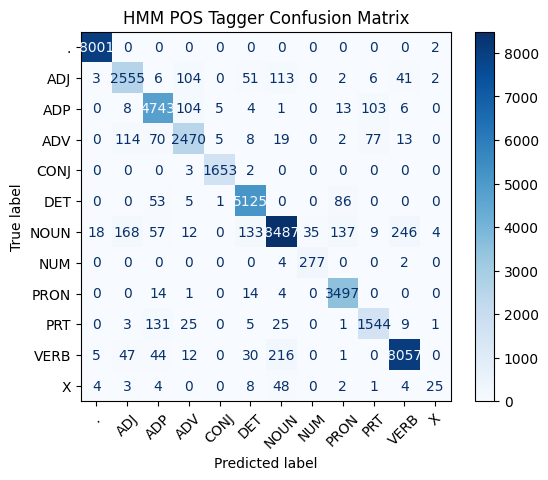

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate(hmm, test_data):
    y_true, y_pred = [], []

    for sent in test_data:
        words = [w for w, t in sent]
        true_tags = [t for w, t in sent]
        pred_tags = hmm.viterbi(words)

        y_true.extend(true_tags)
        y_pred.extend(pred_tags)

    # Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # Confusion matrix
    labels = sorted(list(hmm.tags))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("HMM POS Tagger Confusion Matrix")
    plt.show()

    return y_true, y_pred

# Run evaluation
y_true, y_pred = evaluate(hmm, test_data)

In [3]:
# -------------------
# Demo: show predictions
# -------------------
def show_predictions(hmm, test_data, n=5):
    print("\n--- Demo Predictions ---")
    for i, sent in enumerate(random.sample(test_data, n)):
        words = [w for w, t in sent]
        true_tags = [t for w, t in sent]
        pred_tags = hmm.viterbi(words)

        print(f"\nSentence {i+1}:")
        print("Words:     ", " ".join(words))
        print("True Tags: ", " ".join(true_tags))
        print("Pred Tags: ", " ".join(pred_tags))

# Show 5 random sentences
show_predictions(hmm, test_data, n=5)


--- Demo Predictions ---

Sentence 1:
Words:      well , don't worry .
True Tags:  PRT . VERB VERB .
Pred Tags:  ADV . VERB VERB .

Sentence 2:
Words:      he shouted to the pitcher .
True Tags:  PRON VERB ADP DET NOUN .
Pred Tags:  PRON VERB ADP DET NOUN .

Sentence 3:
Words:      `` i didn't think it was necessary '' .
True Tags:  . PRON VERB VERB PRON VERB ADJ . .
Pred Tags:  . PRON VERB VERB PRON VERB ADJ . .

Sentence 4:
Words:      she wouldn't have , even if he'd asked her .
True Tags:  PRON VERB VERB . ADV ADP PRT VERB PRON .
Pred Tags:  PRON VERB VERB . ADV ADP PRT VERB PRON .

Sentence 5:
Words:      `` but the point is '' , charlotte said , `` there he was , freezing , naked in a little stream of water at ryusenji , all in worship of fudo , the god of fire '' .
True Tags:  . CONJ DET NOUN VERB . . NOUN VERB . . ADV PRON VERB . VERB . ADJ ADP DET ADJ NOUN ADP NOUN ADP NOUN . PRT ADP NOUN ADP NOUN . DET NOUN ADP NOUN . .
Pred Tags:  . CONJ DET NOUN VERB . . NOUN VERB . . ADV 

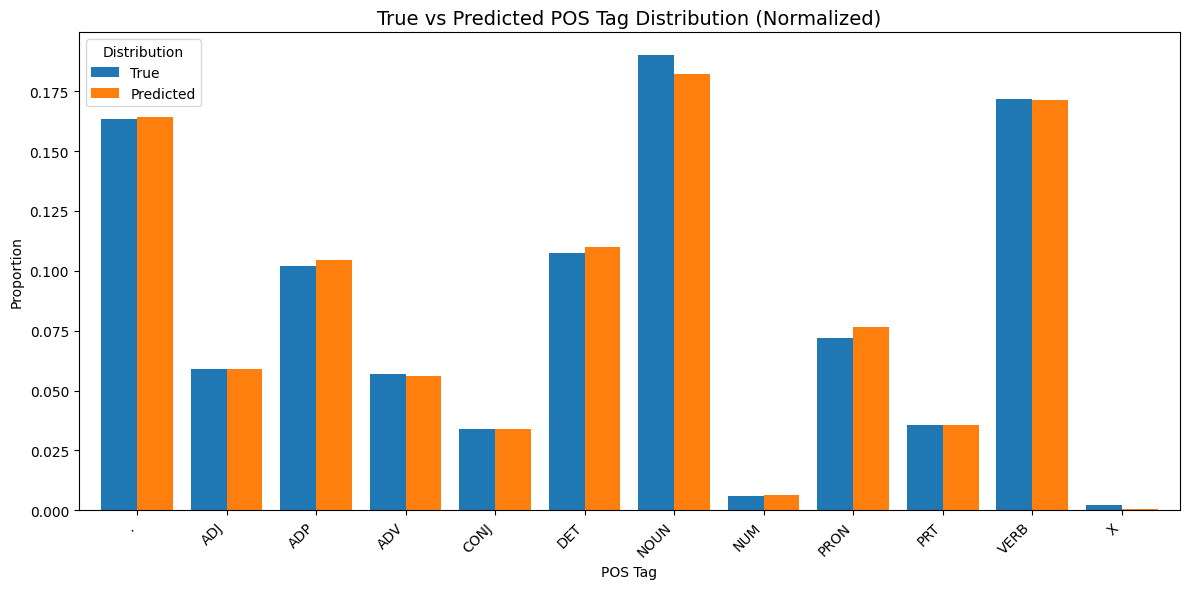

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

def plot_distribution_shift(y_true, y_pred, labels=None):
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))

    true_dist = Counter(y_true)
    pred_dist = Counter(y_pred)

    df = pd.DataFrame({
        "True": [true_dist.get(t, 0) for t in labels],
        "Predicted": [pred_dist.get(t, 0) for t in labels]
    }, index=labels)

    # Normalize to proportions
    df_norm = df.div(df.sum(axis=0), axis=1)

    # Plot
    ax = df_norm.plot(kind="bar", figsize=(12, 6), width=0.8)
    plt.title("True vs Predicted POS Tag Distribution (Normalized)", fontsize=14)
    plt.xlabel("POS Tag")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Distribution")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_distribution_shift(y_true, y_pred, labels=sorted(list(hmm.tags)))

## Demo

In [5]:
def tag_single_sentence(hmm, sentence):
    """Tag a single user-provided sentence with the trained HMM model."""
    words = sentence.strip().lower().split()
    if not words:
        print("Please enter a valid sentence.")
        return

    pred_tags = hmm.viterbi(words)

    print("\n=== HMM POS Tagging Demo ===")
    print(f"Input: {sentence}")
    print("\nWord-Tag pairs:")
    for w, t in zip(words, pred_tags):
        print(f" {w:15} -> {t}")


# Example usage:
user_sentence = input("Enter a sentence: ")
tag_single_sentence(hmm, user_sentence)


=== HMM POS Tagging Demo ===
Input: Hello, how are you?

Word-Tag pairs:
 hello,          -> ADV
 how             -> ADV
 are             -> VERB
 you?            -> VERB
